In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utility.graphing_tools import single_dim_comparison, generate_latex_table_from_csvs, method_name_coverter, heavy_t_comparison
from utility.exps import run_synthetic_experiment, heavy_t

In [285]:
from scipy.spatial import transform
from sqlalchemy.sql import True_
from utility.rectangle import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from matplotlib.patches import Patch
import matplotlib.patches as patches
from matplotlib.lines import Line2D

sns.set_theme(
    style="whitegrid",  # beautiful light grid, best for scientific plots
    context="paper",     # good scaling
    font_scale=1.2,
    rc={
    "lines.linewidth": 2,
    "lines.markersize": 7,
    "axes.labelsize": 11,
    "axes.titlesize": 11,
    "legend.fontsize": 11,
}
)

# Fixed method order (edit to match your actual experiments)
METHOD_ORDER = ["Unscaled Max", "Emp. Copula", "Pop. Oracle", "TSCP", "TSCP-S", "Point CHR", "Bonferroni",  "Naive", "TSCP-GWC", "TSCP-LWC"]

# Consistent color palette across all figures
PALETTE = sns.color_palette("deep", n_colors=len(METHOD_ORDER))
METHOD_COLORS = dict(zip(METHOD_ORDER, PALETTE))

# Consistent markers across all figures
MARKERS = ["o", "s", "D", "^", "v", "<", ">", "P", "X", "*"]
METHOD_MARKERS = dict(zip(METHOD_ORDER, MARKERS))


def method_name_coverter(method_list):
    method_name_list = {}
    for method in method_list:
        if method == "Point_CHR":
            method_name = "Point CHR"
        elif method == "TSCP_R":
            method_name = "TSCP"
        elif method == "TSCP_S":
            method_name = "TSCP-S"
        elif method == "Unscaled":
            method_name = "Unscaled Max"
        elif method == "Empirical_copula":
            method_name = "Emp. Copula"
        elif method == "TSCP_LWC":
            method_name = "TSCP-LWC"
        elif method == "Population_oracle":
            method_name = "Pop. Oracle"
        elif method == "Bonferroni":
            method_name = "Bonferroni"
        elif method == "TSCP_GWC":
            method_name = "TSCP-GWC"
        elif method == "Naive":
            method_name = "Naive"
        method_name_list[method] = method_name
    return method_name_list



    from utility.res_rescaled import one_rect_prediction_regions_nD, check_coverage_rate
    from utility.unscaled import no_scaling_prediction_region
    from utility.data_splitting import data_splitting_scaling_prediction_region, data_spliting_CHR_prediction_region
    from utility.copula import empirical_copula_prediction_region
    scores_cal20 = scores_cal
    LPRO20 = one_rect_prediction_regions_nD(scores_cal20, alpha)
    LPR20 = one_rect_prediction_regions_nD(scores_cal20, alpha, False)[0]
    DSS20 = data_splitting_scaling_prediction_region(scores_cal20, alpha=alpha)
    DSCHR20 = data_spliting_CHR_prediction_region(scores_cal20, alpha=alpha)
    NPR20 = no_scaling_prediction_region(scores_cal20, alpha=alpha)
    EMPC = empirical_copula_prediction_region(scores_cal20, alpha=alpha)

    vol_LPR20 = 0
    for reg in LPR20:
        vol_LPR20 += reg.volume()

    '''
    # Export table info
    table_arr = [["Unscaled", NPR20.volume(), check_coverage_rate(scores_test, NPR20)],
            ["Splitting baseline", DSS20.volume(), check_coverage_rate(scores_test, NPR20)],
            ["Point CHR", DSCHR20.volume(), check_coverage_rate(scores_test, NPR20)],
            ["Empirical copula", EMPC.volume(), check_coverage_rate(scores_test, NPR20)],   
            ["Scaling-based (F)", LPRO20.volume(), check_coverage_rate(scores_test, NPR20)],
            ["Scaling-based", vol_LPR20], check_coverage_rate(scores_test, NPR20)]
    column_labels = ["Method Name", "Volume"]
    table = pd.DataFrame(table_arr, columns=column_labels)
    latex_table = table.to_latex(index=False)
    with open("illustrations_in_paper/n20_d2.tex", "w") as f:
        f.write(latex_table)
    '''

    fig, ax = plt.subplots(1, 1, figsize = (5.5, 2), dpi = 900)

    # Draw test scores and LPR
    graphing_tools_2D(ax, scores=scores_cal20, regions=LPR20, linewidth=0.3)
    LPRO20.draw_2D(ax, boundary_color="Black", fill_color = None, transparency = 1)
    DSS20.draw_2D(ax, boundary_color="Gray", fill_color=None, transparency = 1)
    DSCHR20.draw_2D(ax, boundary_color="Brown", fill_color=None, transparency = 1)
    NPR20.draw_2D(ax, boundary_color="Green", fill_color=None, transparency = 1)
    EMPC.draw_2D(ax, boundary_color="Darkblue", fill_color=None, transparency = 1)

    # Styles
    score_legend = Line2D([0], [0], marker='o', color='w', label='Calibration Scores',
                        markerfacecolor="#1f77b4", markersize=5)
    LPR_legend = Patch(facecolor="#fca3a3", edgecolor='none', label="Scaling-based")
    LPRO_legend = Patch(facecolor="None", edgecolor="Black", label="Scaling-based (F)")
    NPR_legend = Patch(facecolor="None", edgecolor="Green", label="Unscaled")
    DSS_legend = Patch(facecolor="None", edgecolor="Gray", label="Splitting baseline")
    DSCHR_legend = Patch(facecolor="None", edgecolor="Brown", label="Point CHR")
    EMPC_legend = Patch(facecolor="None", edgecolor="Darkblue", label="Empirical copula")
    fig.legend(handles = [NPR_legend, DSS_legend, DSCHR_legend, EMPC_legend, LPRO_legend, LPR_legend, score_legend], loc=legend_loc, ncol = n_cols, bbox_to_anchor=bbox_to_anchor, frameon = False)

    return fig, ax

def prepare_long_form(df_dict, t_dist = False):
    """
    Convert df_dict[method] (wide format) into a single long-form df
    usable by seaborn.
    """
    frames = []
    metric_pairs = [
        ("test_coverage_avg",  "test_coverage_1std"),
        ("coverage_vol_avg",   "coverage_vol_1std"),
        ("runtime_avg",        None)
    ]

    for method, df in df_dict.items():
        df_temp = df.copy()
        df_temp["method"] = method

        for metric, std_col in metric_pairs:
            tmp = df_temp[["method", "n_dim", "n_cals", metric]].copy()
            if t_dist == True:
                tmp = df_temp[["method", "n_dim", "n_cals", "df", metric]].copy()
            tmp = tmp.rename(columns={metric: "metric_value"})
            tmp["metric_name"] = metric

            if std_col is not None:
                tmp["metric_std"] = df_temp[std_col]
            else:
                tmp["metric_std"] = np.nan

            frames.append(tmp)

    long_df = pd.concat(frames, ignore_index=True)
    return long_df
    
def single_dim_comparison(
    df_dict, dim, 
    include_runtime=True,
    include_legend=True,
    figsize=(12, 3),
    legend_bbox=(1.02, 0.5),
    ncols=2,
    direction = "Horizontal",
    ylim = (0.6, 1)
):
    # Gather all data for n_dim == dim
    long_df = prepare_long_form(df_dict)
    df = long_df[long_df["n_dim"] == dim]

    # Panels to plot
    panels = ["test_coverage_avg", "coverage_vol_avg"]
    titles = ["Test Coverage", "Volume"]

    # Add Runtime data
    if include_runtime:
        panels.append("runtime_avg")
        titles.append("Runtime (log10-scale)")

    # Create figure
    if direction == "Horizontal":
        fig, axes = plt.subplots(
            1, len(panels),
            figsize=figsize,
            sharex=True
        )
    else:
        fig, axes = plt.subplots(
            len(panels), 1,
            figsize=figsize,
            sharex=True
        )

    # Enumerate the axes
    axes = axes.flatten()

    for ax, metric, title in zip(axes, panels, titles):

        plot_df = df[df["metric_name"] == metric].copy()

        # Runtime → log10 scale
        if metric == "runtime_avg":
            plot_df["metric_value"] = np.log10(plot_df["metric_value"])

        # Main seaborn line plot
        sns.lineplot(
            data=plot_df,
            x="n_cals",
            y="metric_value",
            hue="method",
            style="method",
            hue_order=METHOD_ORDER,
            style_order=METHOD_ORDER,
            dashes=False,
            palette=METHOD_COLORS,
            markers=METHOD_MARKERS,
            ax=ax,
            linewidth = 2,
            markersize = 8
        )

        # Add fancy gray panel title
        rect = patches.Rectangle(
            (0, 1.02), 1, 0.14,
            transform = ax.transAxes,
            color = "#E0E0E0",
            clip_on = False,
            zorder = -1
        )
        ax.add_patch(rect)

        # Axis scaling
        ax.set_xscale("log")
        ticks = sorted(plot_df["n_cals"].unique())
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Calibration Sample Size")
        ax.set_ylabel("Mean")
        

        if metric == "coverage_vol_avg" and dim > 2:
            ax.set_yscale("log")
        if metric == "test_coverage_avg":
            ax.axhline(0.90, color="green", linestyle="--", linewidth=1)
            ax.set_ylim(ylim)

        ax.set_title(title)
        ax.grid(True)

    # Legend (single shared)
    if include_legend:
        handles, labels = axes[0].get_legend_handles_labels()
        methods_drawn = sorted(long_df["method"].unique())   # or filtered per subplot

        filtered_handles = []
        filtered_labels = []

        for h, lbl in zip(handles, labels):
            if lbl in methods_drawn:
                filtered_handles.append(h)
                filtered_labels.append(lbl)

        # Global legend
        fig.legend(
            filtered_handles, filtered_labels,
            loc="center left",
            bbox_to_anchor=legend_bbox,
            frameon=False,
            ncol=ncols,
            title = "Method"
        )
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    return fig, axes

def heavy_t_comparison(
    df_dict, dim, sample,
    include_runtime=True,
    include_legend=True,
    figsize=(12, 3),
    legend_bbox=(1.02, 0.5),
    ncols=2,
    direction = "Horizontal",
    ylim = (0.6, 1)
):

    # Gather all data for n_dim == dim
    long_df = prepare_long_form(df_dict, t_dist=True)
    df = long_df[(long_df["n_dim"] == dim) & (long_df["n_cals"] == sample)]

    # Panels to plot
    panels = ["test_coverage_avg", "coverage_vol_avg"]
    titles = ["Test Coverage", "Volume"]

    # Add Runtime data
    if include_runtime:
        panels.append("runtime_avg")
        titles.append("Runtime (log10-scale)")

    # Create figure
    if direction == "Horizontal":
        fig, axes = plt.subplots(
            1, len(panels),
            figsize=figsize,
            sharex=True
        )
    else:
        fig, axes = plt.subplots(
            len(panels), 1,
            figsize=figsize,
            sharex=True
        )

    # Enumerate the axes
    axes = axes.flatten()

    for ax, metric, title in zip(axes, panels, titles):

        plot_df = df[(df["metric_name"] == metric) & (df["df"] < 10)].copy()

        # Runtime → log10 scale
        if metric == "runtime_avg":
            plot_df["metric_value"] = np.log10(plot_df["metric_value"])


        # Main seaborn line plot
        sns.lineplot(
            data=plot_df,
            x="df",
            y="metric_value",
            hue="method",
            style="method",
            hue_order=METHOD_ORDER,
            style_order=METHOD_ORDER,
            dashes=False,
            palette=METHOD_COLORS,
            markers=METHOD_MARKERS,
            ax=ax,
            linewidth = 2,
            markersize = 8
        )

        # Add fancy gray panel title
        rect = patches.Rectangle(
            (0, 1.02), 1, 0.14,
            transform = ax.transAxes,
            color = "#E0E0E0",
            clip_on = False,
            zorder = -1
        )
        ax.add_patch(rect)

        # Axis scaling
        ax.set_xscale("log")
        ticks = sorted(plot_df["df"].unique())
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Degree of Freedoms")
        ax.set_ylabel("Mean")
        

        if metric == "coverage_vol_avg" and dim > 2:
            ax.set_yscale("log")
        if metric == "test_coverage_avg":
            ax.axhline(0.90, color="green", linestyle="--", linewidth=1)
            ax.set_ylim(ylim)

        ax.set_title(title)
        ax.grid(True)

    # Legend (single shared)
    if include_legend:
        handles, labels = axes[0].get_legend_handles_labels()
        methods_drawn = sorted(long_df["method"].unique())   # or filtered per subplot

        filtered_handles = []
        filtered_labels = []

        for h, lbl in zip(handles, labels):
            if lbl in methods_drawn:
                filtered_handles.append(h)
                filtered_labels.append(lbl)

        # Global legend
        fig.legend(
            filtered_handles, filtered_labels,
            loc="center left",
            bbox_to_anchor=legend_bbox,
            frameon=False,
            ncol=ncols,
            title = "Method"
        )
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    return fig, axes

def compare_across_dims(
    df_dict, figsize=(12, 3),
    include_legend=True,
    legend_bbox = (1.02, 0.5),
    ncols=2,
    ylim = (0.7, 1)
):
    # ------------------------------------------
    # Convert df_dict into a long-form dataframe
    # ------------------------------------------
    # Gather all data for n_dim == dim
    long_df = prepare_long_form(df_dict)

    # ------------------------------------------
    # Prepare subplots
    # ------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Panels to plot
    panels = ["test_coverage_avg", "coverage_vol_avg", "runtime_avg"]
    titles = ["Test Coverage", "Volume", "Runtime"]

    axes = axes.flatten()

    for ax, metric, title in zip(axes, panels, titles):

        plot_df = long_df[long_df["metric_name"] == metric].copy()

        # Runtime → log10 scale
        if metric == "runtime_avg":
            plot_df["metric_value"] = np.log10(plot_df["metric_value"])


        sns.lineplot(
                data=plot_df,
                x="n_dim",
                y="metric_value",
                hue="method",
                style="method",
                hue_order=METHOD_ORDER,
                style_order=METHOD_ORDER,
                dashes=False,
                palette=METHOD_COLORS,
                markers=METHOD_MARKERS,
                ax=ax,
                linewidth = 2,
                markersize = 8
            )

        # Add fancy gray panel title
        rect = patches.Rectangle(
                (0, 1.02), 1, 0.14,
                transform = ax.transAxes,
                color = "#E0E0E0",
                clip_on = False,
                zorder = -1
        )
        ax.add_patch(rect)

        # Axis scaling
        ax.set_xscale("log")
        ticks = sorted(plot_df["n_dim"].unique())
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)
        ax.set_xlabel("Dimensions")
        ax.set_ylabel("Mean")


        if metric == "coverage_vol_avg":
            ax.set_yscale("log")
        if metric == "test_coverage_avg":
            ax.axhline(0.90, color="green", linestyle="--", linewidth=1)
            ax.set_ylim(ylim)
        if metric == "runtime_avg":
            ax.set_ylabel(r"$\log_{10}$(Mean)")

        ax.set_title(title)
        ax.grid(True)

    
    # Legend (single shared)
    if include_legend:
        handles, labels = axes[0].get_legend_handles_labels()
        methods_drawn = sorted(long_df["method"].unique())   # or filtered per subplot

        filtered_handles = []
        filtered_labels = []

        for h, lbl in zip(handles, labels):
            if lbl in methods_drawn:
                filtered_handles.append(h)
                filtered_labels.append(lbl)

        # Global legend
        fig.legend(
            filtered_handles, filtered_labels,
            loc="center left",
            bbox_to_anchor=legend_bbox,
            frameon=False,
            ncol=ncols,
            title = "Method"
        )
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    return fig, axes

def single_dim_text_file(methods, dim, sample_list, trials, alpha, noise_list, log_scale = True, output_path = "results.txt"):
    from utility.exps import run_synthetic_experiment
    output = {}
    for method in methods:
        output[method] = run_synthetic_experiment(dim_list= [dim], sample_list=sample_list, alpha_list=[alpha], trials=trials, method=method, noises_list=noise_list, log_scale=log_scale)
    with open(output_path, "w") as f:
        for method, df in output.items():
            f.write(f"Method: {method}\n")
            f.write(df.to_string(index=False))
            f.write("\n\n" + "-"*60 + "\n\n")

def generate_latex_table_from_csvs(
    file_dict, dim, 
    noise_type, 
    method_exlude = ["Naive", "Emp. Copula"],
    filename="table_dX.tex"
):

    combined = []

    # Combine all CSV results
    for method, data in file_dict.items():
        df = data.copy()
        df["method"] = method
        combined.append(df)

    df_all = pd.concat(combined)

    # Filter by dimension
    df_all = df_all[df_all["n_dim"] == dim]
    df_all = df_all.sort_values(by=["n_cals", "method"])

    lines = []
    lines.append("\\begin{tabular}{l l c c c}")
    lines.append("\\toprule")
    lines.append("(n, d, Noise) & Method & Coverage & Volume & Runtime \\\\")
    lines.append("\\midrule")

    for n_cals in df_all["n_cals"].unique():

        subset = df_all[df_all["n_cals"] == n_cals]
        n_methods = len(subset)

        # --- EXCLUDE CERTAIN METHODS FROM MIN-VOLUME SEARCH ---
        subset_for_min = subset[
            ~subset["method"].isin(["Naive", "Emp. Copula"])
        ]
        if subset_for_min.empty:  # safety fallback
            subset_for_min = subset

        min_vol = subset_for_min["coverage_vol_avg"].min()
        # ------------------------------------------------------

        for idx, (_, row) in enumerate(subset.iterrows()):

            # Multirow label for n_cals
            cal_label = (
                f"\\multirow{{{n_methods}}}{{*}}{{({int(n_cals)}, {int(dim)}, {noise_type})}}"
                if idx == 0 else ""
            )

            # Coverage formatting
            coverage_avg = row['test_coverage_avg']
            coverage_std = row['test_coverage_1std']
            coverage_text = f"{coverage_avg:.3f} ({coverage_std:.3f})"

            # Volume formatting
            vol_mean = row['coverage_vol_avg']
            vol_std = row['coverage_vol_1std']
            volume_text = f"{vol_mean:.3e}({vol_std:.3e})"

            # ========= BLUE HIGHLIGHT FOR FAILED COVERAGE =========
            if coverage_avg <= 0.89:
                coverage_text = f"\\textcolor{{blue}}{{{coverage_text}}}"
            # ======================================================

            # ========= RED HIGHLIGHT FOR MINIMUM VOLUME ===========
            if (
                row["method"] not in ["Naive", "Emp. Copula"] 
                and vol_mean == min_vol
            ):
                volume_text = f"\\textcolor{{red}}{{{volume_text}}}"
            # ======================================================

            # Runtime formatting
            runtime_text = f"{row['runtime_avg']:.3f}"

            # Compose row
            lines.append(
                f"{cal_label} & {row['method']} & "
                f"{coverage_text} & {volume_text} & {runtime_text} \\\\"
            )

        lines.append("\\midrule")

    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")

    # Output filename
    filename = filename.replace("dX", f"d{dim}")

    with open(filename, "w") as f:
        f.write("\n".join(lines))



def format_pm(mean, std, sci=False, highlight=False):
    """Format as mean(std), optionally in scientific notation and highlighted."""
    if pd.isna(mean) or pd.isna(std):
        return f"\\text{{inf}}"
    if sci:
        mean_str = f"{mean:.3e}"
        std_str = f"{std:.3e}"
    else:
        mean_str = f"{mean:.3f}"
        std_str = f"{std:.3f}"
    result = f"{mean_str}({std_str})"
    if highlight:
        return f"\\textcolor{{red}}{{{result}}}"
    return result


def extract_stats(df):
    """Return dict[method] = (cov, cov_std, vol, vol_std)."""
    stats = {}
    for _, row in df.iterrows():
        m = row["Methods"].strip()
        stats[m] = (
            row["test_coverage_avg"],
            row["test_coverage_1std"],
            row["coverage_vol"],
            row["coverage_vol_1std"],
        )
    return stats

def build_panel(panel_datasets, methods_order, caption):
    lines = []
    header_cols = " & ".join(
        [f"\\multicolumn{{2}}{{c}}{{{name} $(d={d},\\, n={n})$}}" for name, _, d, n in panel_datasets]
    )
    subheaders = " & ".join(["Coverage & Volume"] * len(panel_datasets))

    lines.append("\\begin{subtable}{\\textwidth}")
    lines.append("\\centering")
    lines.append("\\begin{tabular}{l" + "c c " * len(panel_datasets) + "}")
    lines.append("\\toprule")
    lines.append("\\textbf{Method} & " + header_cols + " \\\\")
    cmid = "".join([f"\\cmidrule(lr){{{2*i+2}-{2*i+3}}}" for i in range(len(panel_datasets))])
    lines.append(cmid)
    lines.append("& " + subheaders + " \\\\")
    lines.append("\\midrule")

    dfs = []
    for _, file, _, _ in panel_datasets:
        df = pd.read_csv(file)
        dfs.append(extract_stats(df))

    # Find min volume per dataset for highlighting
    min_vols = []
    for data in dfs:
        vols = [v[2] for v in data.values() if pd.notna(v[2])]
        min_vols.append(min(vols) if vols else None)

    # Build each row (method)
    for method in methods_order:
        row_parts = [method]
        for j, data in enumerate(dfs):
            if method in data:
                cov, cov_std, vol, vol_std = data[method]
                cov_str = format_pm(cov, cov_std, sci=False)
                highlight = (vol == min_vols[j])
                vol_str = format_pm(vol, vol_std, sci=True, highlight=False)
            else:
                cov_str, vol_str = "--", "--"
            row_parts += [cov_str, vol_str]
        lines.append(" & ".join(row_parts) + " \\\\")

    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append(f"\\subcaption{{{caption}}}")
    lines.append("\\end{subtable}")
    return "\n".join(lines)


# Testing Coverage on Six Distributions

We test all methods discussed in the experiment section of our paper on four different distributions: Gaussian, Gaussian with unit noise, Laplace, Gamma, Mixed, Cauchy.
We report test coverage, volume, and runtime with their one standard deviation. 

In [ ]:
dim_list = [2, 10]
sample_list = [30, 50, 100, 300, 500]
alpha_list = [0.1]
trial = 200
noise_list_unit = [np.repeat(1, 2), np.repeat(1, 10)]
noise_type_list = ["Gaussian", "Unit_Gaussian", "Laplace", "Gamma", "Mixed"]
method_list_baselines = ["Point_CHR", "Unscaled", "Empirical_copula", "TSCP_R"]
method_name_list_baselines = method_name_coverter(method_list=method_list_baselines)

for noise_type in noise_type_list:

    folder_name = "gaussian" if noise_type == "Unit_Gaussian" else noise_type.lower()
    dict1 = {}
    for method in method_list_baselines:
        results = pd.read_csv("syn_exps/"+folder_name+"/"+method.lower()+"_"+noise_type.lower()+".csv")
        dict1[method_name_list_baselines[method]] = results
    for dim in dim_list:
        fig, axes = single_dim_comparison(df_dict=dict1, dim = 10, include_runtime=False, include_legend=True, legend_bbox=(0.85, 0.5), figsize=(6.5,2.5), ncols=1)
        fig.savefig(f"syn_exps/figures/baselines/{noise_type.lower()}_{dim}d.pdf", bbox_inches='tight')
        generate_latex_table_from_csvs(dict1, dim, noise_type, filename=f"syn_exps/figures/baselines/{noise_type.lower()}_{dim}d.tex")


# Testing Our Method on t-distribution

We test our method on the student t distribution with fixed dim and fixed sample but various degree of freedome to see how robust our method is with heavy tailed error.

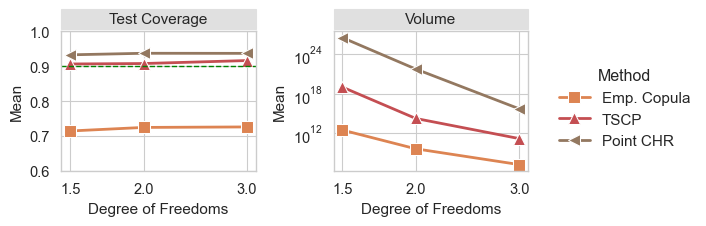

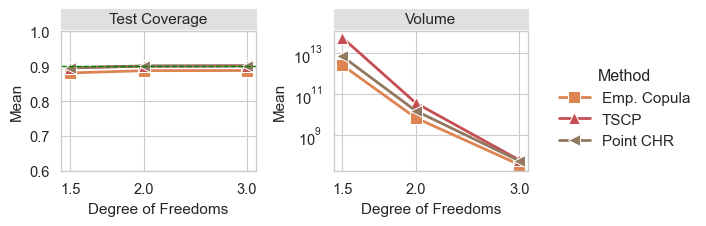

In [297]:
dim_list_t = [10]
df_list = [1.5, 2, 3, 10, 30]
sample_list_t = [30, 500]
method_list_t = ["Point_CHR", "TSCP_R", "Empirical_copula"]
method_name_list_t = method_name_coverter(method_list=method_list_t)

dict_t = {}
for method in method_list_t:
    results = pd.read_csv("syn_exps/t/"+method.lower()+"_t.csv")
    dict_t[method_name_list_t[method]] = results

for dim in dim_list_t:
    for sample in sample_list_t:
        fig, axes = heavy_t_comparison(df_dict=dict_t, dim=dim, sample = sample, ncols = 1, legend_bbox=(0.85, 0.5), figsize=(6.5,2.5), include_runtime=False)
        fig.savefig(f"syn_exps/figures/t/t_n{sample}_{dim}d.pdf", bbox_inches='tight')
        generate_latex_table_from_csvs(dict_t, dim, "Student-t", filename=f"syn_exps/figures/t/t_n{sample}_{dim}d.tex")

# Comparison of Our Methods on 2D-Laplace

We compare all four variants of our method, including the population oracle on 2D Laplace noise. We only do it for 2D because the TSCP-LWC method is almost impossible to finish with large dimensions, but the message overall should be clear.

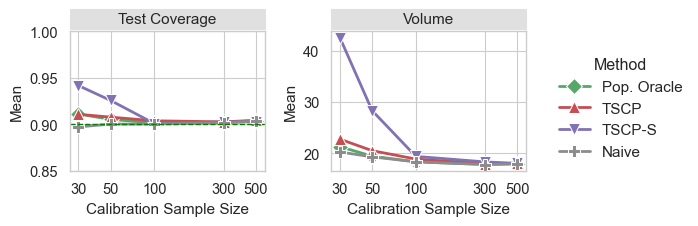

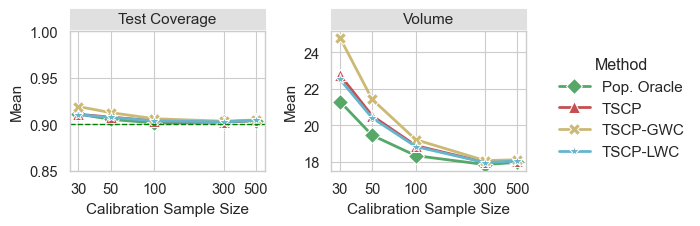

In [291]:
method_list_ours1 = ["TSCP_R", "TSCP_S", "Population_oracle", "Naive"]
method_name_list_ours1 = method_name_coverter(method_list_ours1)

method_list_ours2 = ["TSCP_R", "TSCP_GWC", "TSCP_LWC", "Population_oracle"]
method_name_list_ours2 = method_name_coverter(method_list_ours2)

dict_ours1 = {}
for method in method_list_ours1:
    results = pd.read_csv("syn_exps/laplace/"+method.lower()+"_laplace.csv")
    dict_ours1[method_name_list_ours1[method]] = results
fig, axes = single_dim_comparison(df_dict=dict_ours1, dim = 2, include_runtime=False, include_legend=True, legend_bbox=(0.85, 0.5), figsize=(6.5,2.5), ncols=1, ylim = (0.85, 1))
fig.savefig("syn_exps/figures/ours/ours_approximation_2d.pdf", bbox_inches='tight')

dict_ours2 = {}
for method in method_list_ours2:
    results = pd.read_csv("syn_exps/laplace/"+method.lower()+"_laplace.csv")
    dict_ours2[method_name_list_ours2[method]] = results
fig, axes = single_dim_comparison(df_dict=dict_ours2, dim = 2, include_runtime=False, include_legend=True, legend_bbox=(0.85, 0.5), figsize=(6.5,2.5), ncols=1, ylim = (0.85, 1))
fig.savefig("syn_exps/figures/ours/ours_containment_2d.pdf", bbox_inches='tight')

dict_ours = dict_ours1|dict_ours2
generate_latex_table_from_csvs(dict_ours, dim = 2, noise_type = "Laplace", filename="syn_exps/figures/ours/ours_comparisons_2d.tex")

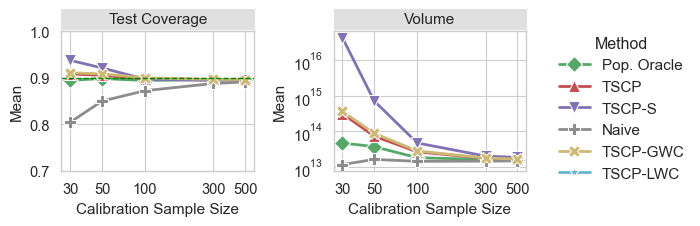

In [290]:
method_list_ours3 = ["TSCP_R", "TSCP_GWC", "TSCP_LWC", "TSCP_S", "Population_oracle", "Naive"]
method_name_list_ours3 = method_name_coverter(method_list_ours3)

dict_ours3 = {}
for method in method_list_ours3:
    results = pd.read_csv("syn_exps/laplace/"+method.lower()+"_laplace.csv")
    dict_ours3[method_name_list_ours3[method]] = results
fig, axes = single_dim_comparison(df_dict=dict_ours3, dim = 10, include_runtime=False, include_legend=True, legend_bbox=(0.85, 0.5), figsize=(6.5,2.5), ncols=1, ylim = (0.7, 1))
fig.savefig("syn_exps/figures/ours/ours_containment_10d.pdf", bbox_inches='tight')

# Runtime Comparison on 2D Laplace

In [ ]:
method_list_runtime = ["TSCP_LWC", "TSCP_R", "Point_CHR", "Empirical_copula"]
method_name_list_runtime = method_name_coverter(method_list_runtime)
dict1 = {}
for method in method_list_runtime:
    results = pd.read_csv(f"syn_exps/laplace/{method.lower()}_laplace_30sample.csv")
    dict1[method_name_list_runtime[method]] = results
fig, ax = compare_across_dims(df_dict=dict1, ncols=5, legend_bbox=(0.15, 1.05), figsize=(10, 2.5), ylim=(0.20, 1))
fig.savefig("syn_exps/figures/ours/ours_runtime.pdf", bbox_inches='tight')

In [298]:
# Import general packages
import hashlib
import numpy as np
import pandas as pd
import time
from typing import List, Optional

# Import training packages
from sklearn.linear_model import LinearRegression, MultiTaskLasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Dataset loader
from ucimlrepo import fetch_ucirepo 
from scipy.io import arff

# Import utility packages
from utility.data_generator import make_multitarget_regression
from utility.res_rescaled import check_coverage_rate, standardized_prediction
from utility.unscaled import unscaled_prediction, bonferroni_prediction
from utility.data_splitting import data_splitting_standardized_prediction, data_spliting_CHR_prediction, data_splitting_oracle_prediction, naive_prediction
from utility.copula import empirical_copula_prediction


In [480]:
def stable_hash(*args):
    """
    Create a reproducible hash from input arguments, useful for random seeds.

    Parameters
    ----------
    *args : Any
        Sequence of inputs to be hashed.

    Returns
    -------
    int
        A deterministic hash value based on inputs.
    """
    key = "_".join(str(a) for a in args)
    return int(hashlib.sha256(key.encode()).hexdigest(), 16) % (2**32)

def function_choice(scores, alpha, method, mu = None, std = None):
    """
    Select and run the prediction region method based on input string.

    Parameters
    ----------
    scores : np.ndarray
        Score values used to construct prediction regions.
    alpha : float
        Miscoverage level.
    method : str
        The method name specifying which region construction to use.

    Returns
    -------
    depends on method
        Either a single region (Rectangle) or list of regions.
    """

    # Scaled methods
    #if method == "Scaled (Full)":
    #    return scaled_prediction(scores=scores, alpha=alpha, short_cut=False)
    #elif method == "Scaled (Shortcut)":
    #    return scaled_prediction(scores=scores, alpha=alpha, short_cut=True)
    #elif method == "Scaled (Data Splitting)":
    #    return data_splitting_scaled_prediction(scores=scores, alpha=alpha)

    # Standardized methods
    if method == "TSCP_LWC":
        return standardized_prediction(scores=scores, alpha=alpha, short_cut=False)
    elif method == "TSCP_R":
        return standardized_prediction(scores=scores, alpha=alpha, short_cut=True)
    elif method == "TSCP_GWC":
        return standardized_prediction(scores=scores, alpha=alpha, method= "GWC", short_cut=True)
    elif method == "TSCP_S":
        return data_splitting_standardized_prediction(scores=scores, alpha=alpha)
    elif method == "Population_oracle":
        return data_splitting_oracle_prediction(scores = scores, mu = mu, std = std, alpha=alpha)
    elif method == "Naive":
        return naive_prediction(scores=scores, alpha=alpha)
    
    # Point CHR
    elif method == "Point_CHR":
        return data_spliting_CHR_prediction(scores=scores, alpha=alpha)
    
    # Empirical copuls
    elif method == "Empirical_copula":
        return empirical_copula_prediction(scores=scores, alpha=alpha)

    # No scaling methods
    elif method == "Unscaled":
        return unscaled_prediction(scores=scores, alpha=alpha)
    elif method == "Bonferroni":
        return bonferroni_prediction(scores=scores, alpha=alpha)

def run_energy_toy(num_splits, alpha = 0.1, cal_size = 0.2, test_size = 0.2, case = 1):

    methods = [
            "Unscaled",
            "TSCP_R", 
            "Point_CHR", 
            "Empirical_copula" 
            ]

    # Load data
    energy_efficiency = fetch_ucirepo(id=242) 
        
    X = energy_efficiency.data.features
    y = energy_efficiency.data.targets
    model= RandomForestRegressor(
                n_estimators=200,          
                max_depth=None,            
                min_samples_split=2,       
                min_samples_leaf=1,        
                max_features=1.0,          # Use all features at each split
                bootstrap=True,            
                random_state=77,
                n_jobs=-1
            )


    for i in range(num_splits):

        X_train, X_cal_test, y_train, y_cal_test = train_test_split(X, y, test_size=test_size+cal_size, random_state=stable_hash(i))
        X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, test_size=test_size/(cal_size+test_size), random_state=stable_hash(i))

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        prediction_cal = model.predict(X_cal)
        scores_cal = np.asarray(np.abs(prediction_cal-y_cal), dtype=np.float64)
        y_test = y_test.reset_index(drop=True)
        pred_test = model.predict(X_test)
        scores_test = np.abs(pred_test - y_test)

        # Run the methods
        predictions = {}
        for index, method in enumerate(methods): 
            prediction = function_choice(scores_cal, alpha, method) 
            predictions[method] = prediction
        

        condition_a = predictions["TSCP_R"].volume() < predictions["Point_CHR"].volume()
        condition_b = predictions["Point_CHR"].volume() < predictions["Unscaled"].volume()


        if condition_a and condition_b:
            for index, row in y_test.reset_index(drop=True).iterrows(): 
                y0 = model.predict(X_test)[index] 
                sample = np.asarray(np.abs(y0-row))

                if case == 1:
                    if (predictions["TSCP_R"].contains(sample)) and predictions["Unscaled"].contains(sample) and not predictions["Empirical_copula"].contains(sample):

                        temp = {}
                        for m in methods:

                            upper = predictions[m].upper

                            temp[m] = {
                                "Outcomes 1": (f"{y0[0]-upper[0]:.3f}", f"{y0[0]+upper[0]:.3f}"),
                                "Outcomes 2": (f"{y0[1]-upper[1]:.3f}", f"{y0[1]+upper[1]:.3f}"),
                                "Volume": f"{predictions[m].volume():.3f}"
                            }
                            

                        temp["Ground Truth"] = row.values 
                        
                        return temp
                    
                
                else: 
                    if predictions["TSCP_R"].contains(sample):
                        
                        temp = {}
                        for m in methods:

                            upper = predictions[m].upper

                            temp[m] = {
                                "Outcomes 1": (f"{y0[0]-upper[0]:.3f}", f"{y0[0]+upper[0]:.3f}"),
                                "Outcomes 2": (f"{y0[1]-upper[1]:.3f}", f"{y0[1]+upper[1]:.3f}"),
                                "Volume": f"{predictions[m].volume():.3f}"
                            }

                        temp["Ground Truth"] = row.values 
                        
                        return temp

In [481]:
run_energy_toy(10, 0.1, 0.05, 0.2, 1)

{'Unscaled': {'Outcomes 1': ('36.170', '43.406'),
  'Outcomes 2': ('35.613', '42.849'),
  'Volume': '13.090'},
 'TSCP_R': {'Outcomes 1': ('38.745', '40.830'),
  'Outcomes 2': ('34.506', '43.956'),
  'Volume': '4.926'},
 'Point_CHR': {'Outcomes 1': ('38.754', '40.821'),
  'Outcomes 2': ('32.320', '46.142'),
  'Volume': '7.142'},
 'Empirical_copula': {'Outcomes 1': ('38.828', '40.748'),
  'Outcomes 2': ('35.613', '42.849'),
  'Volume': '3.473'},
 'Ground Truth': array([38.82, 39.37])}